<a href="https://colab.research.google.com/github/sltou/AD/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source code to solve for ODE from https://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations

# Part 1

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import multiprocessing as mp
import itertools
from google.colab import files

In [0]:
def diffeq(z,t,alpha,k,a,b,omega):
  x = z[0]
  y = z[1]
  xdot = alpha*(y+x-x**3/3+k)
  ydot = -1/alpha*(omega**2*x-a+b*y)
  zdot = [xdot,ydot]
  return zdot

In [0]:
# initial condition
z0 = [0,0]

# number of seconds
n = 100

#sample frequency
fs = 64

# time points
t = np.linspace(0,n,n*fs)

In [0]:
# store solution
x = np.empty_like(t)
y = np.empty_like(t)
# record initial conditions
x[0] = z0[0]
y[0] = z0[1]

In [0]:
#play around with multiprocessing
pal=mp.Pool(100)

In [0]:
# solve ODE for k=-0.5
z = odeint(diffeq,z0,t,args=(3,-0.5,0.7,0.8,1)) #use k =-0.5
# store solution for plotting
x = z[:,0]
y = z[:,1]

# solve ODE for k=-0.5, old code
for i in range(1,n*fs):
    # span for next time step
    # solve for next step
    z = odeint(diffeq,z0,t,args=(3,-0.5,0.7,0.8,1)) #use k =-0.5
    # store solution for plotting
    x[i] = z[1][0]
    y[i] = z[1][1]
    # next initial condition
    z0 = z[1]


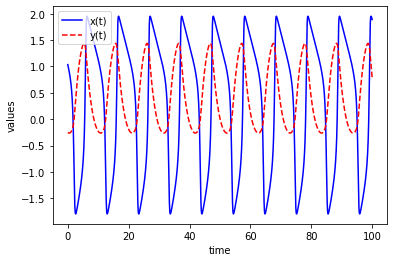

In [38]:
# plot results for k=-0.5
plt.plot(t,x,'b-',label='x(t)')
plt.plot(t,y,'r--',label='y(t)')
plt.ylabel('values')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()

Yay it oscillates!

In [3]:
#calculate frequency of the signal x and y, install the necessary packages
!pip install spectrum
import spectrum

     |████████████████████████████████| 235kB 2.7MB/s 
  Created wheel for spectrum: filename=spectrum-0.7.6-cp36-cp36m-linux_x86_64.whl size=234247 sha256=3dad757081b92dcdc0aec1e193dc6c2f6fe2e0e64d5233ff2dd81aeda7f132fe
  Stored in directory: /root/.cache/pip/wheels/7b/a1/1f/16e3bd0418dc16201a4f2e696ab00de3e3c95549cba7df5d13
Successfully built spectrum


In [0]:
p = spectrum.Periodogram(x,sampling=fs) #the non-parametric PSD
p.run()

In [22]:
 #find the frequency that is greater than 0 that has maximum psd
print(p.frequencies()[np.where(p.psd[1:] == np.amax(p.psd[1:]))[0][0]+1])

0.1


Frequency peaks at 0.1 Hz and the other shows its harmonics

More documentation on the spectrum library https://pyspectrum.readthedocs.io/en/latest/quickstart.html

Now that we successfully extract the instrinsic frequency for one k (or z in the project pdf..), we can make a for loop to test different ks

In [0]:
def df2freq(k): #lets just say we only care about x
  z = odeint(diffeq,z0,t,args=(3,k,0.7,0.8,1))
  x = z[:,0]
  #y = z[:,1]
  p_x = spectrum.Periodogram(x,sampling=fs)
  p_x.run()
  #p_y = spectrum.Periodogram(y,sampling=fs)
  return p_x.frequencies()[np.where(p_x.psd[1:] == np.amax(p_x.psd[1:]))[0][0]+1]

In [27]:
#define steps for iteration
step = 0.005
begin = -2
end = 0
print('Time to execute as a single process: ', end='')
%timeit x_freq = [df2freq(k) for k in np.arange(begin,end,step)]

Time to execute as a single process: 1 loop, best of 3: 6.67 s per loop


In [30]:
k = np.arange(begin,end,step)
print('Time to execute as multiple processes: ', end='')
%timeit x_freq = pal.map(df2freq,k)
# for this case, it's actually slower to multi-process in this case because of the overhead

Time to execute as multiple processes: 1 loop, best of 3: 6.89 s per loop


In [0]:
x_freq = [df2freq(k) for k in np.arange(begin,end,step)]

In [0]:
 #OLD CODE DONT USE define steps for iteration
 step = 0.005
 begin = -2
 end = 0
 x_freq = np.zeros(round((end-begin)/step))
 y_freq = np.zeros(round((end-begin)/step))
 idx = 0
 for k in np.arange(begin,end,step):
    z = odeint(diffeq,z0,t,args=(3,k,0.7,0.8,1))
    x = z[:,0]
    y = z[:,1]
    p_x = spectrum.Periodogram(x,sampling=fs)
    p_y = spectrum.Periodogram(y,sampling=fs)
    x_freq[idx] = p_x.frequencies()[np.where(p_x.psd[1:] == np.amax(p_x.psd[1:]))[0][0]+1]
    y_freq[idx] = p_y.frequencies()[np.where(p_y.psd[1:] == np.amax(p_y.psd[1:]))[0][0]+1]
    idx = idx + 1

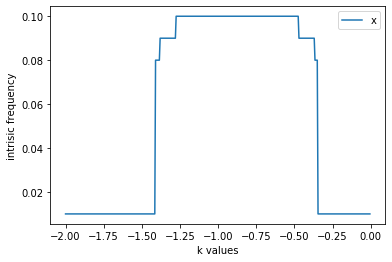

In [46]:
#plot the result!
plt.plot(np.arange(begin,end,step),x_freq, label='x')
#plt.plot(np.arange(begin,end,step),y_freq, label='y')
plt.xlabel('k values')
plt.ylabel('intrisic frequency')
plt.legend(loc='best')

# Part 2

In [0]:
f1_begin = -1.3
f1_end = -0.3 +0.01
f1_step = 0.1
c_begin = 0
c_end = 1.01
c_step = 0.1
n = 100
fs = 64

In [0]:
#for loop only, no fancy parallel processing

x1 = np.zeros((round((f1_end-f1_begin)/f1_step)+1, round((c_end-c_begin)/c_step)+1,n*fs))
x2 = np.zeros((round((f1_end-f1_begin)/f1_step)+1, round((c_end-c_begin)/c_step)+1,n*fs))
z1_old = [0,0]
z2_old = [0,0]
k2 = -1.3
k1_idx = 0
t = np.linspace(0,n,n*fs)
for k1 in np.arange(f1_begin, f1_end, f1_step):
  c_idx = 0
  for c in np.arange(c_begin, c_end, c_step):
    for i in range(1,n*fs):
      z1 = odeint(diffeq,z1_old,[t[i-1],t[i]],args=(3,k1+c*z2_old[0],0.7,0.8,1)) #inclement 1 time step each
      z2 = odeint(diffeq,z2_old,[t[i-1],t[i]],args=(3,k2+c*z1_old[0],0.7,0.8,1))
      x1[k1_idx, c_idx, i] = z1[1][0]
      x2[k1_idx, c_idx, i] = z2[1][0]
      z1_old = z1[1]
      z2_old = z2[1]
    c_idx = c_idx + 1
  k1_idx = k1_idx + 1



In [0]:
x1_2d = x1.reshape(((round((f1_end-f1_begin)/f1_step)+1)*(round((c_end-c_begin)/c_step)+1),n*fs))
x2_2d = x2.reshape(((round((f1_end-f1_begin)/f1_step)+1)*(round((c_end-c_begin)/c_step)+1),n*fs))

In [0]:
#set up parallel processing
k1 = np.arange(f1_begin, f1_end, f1_step)
c = np.arange(c_begin, c_end, c_step)
paramlist = list(itertools.product(k1,c))
pal=mp.Pool(10)

In [0]:
def simulation(k1,c):
  x1 = np.zeros(n*fs)
  x2 = np.zeros(n*fs)
  z1_old = [0,0]
  z2_old = [0,0]
  k2 = -1.3
  t = np.linspace(0,n,n*fs)
  for i in range(1,n*fs):
      z1 = odeint(diffeq,z1_old,[t[i-1],t[i]],args=(3,k1+c*z2_old[0],0.7,0.8,1)) #inclement 1 time step each
      z2 = odeint(diffeq,z2_old,[t[i-1],t[i]],args=(3,k2+c*z1_old[0],0.7,0.8,1))
      x1[i] = z1[1][0]
      x2[i] = z2[1][0]
      z1_old = z1[1]
      z2_old = z2[1]
  return (x1,x2)

In [34]:
print('Time to execute as multiple processes: ', end='')
%timeit x1x2 = pal.starmap(simulation,iterable=paramlist)

Time to execute as multiple processes: 1 loop, best of 3: 2min 19s per loop


In [0]:
x1x2 = pal.starmap(simulation,iterable=paramlist)

In [0]:
# lets save the time series results
# https://colab.research.google.com/github/geekmj/python-tutorials/blob/master/numpy-basics/save-array-to-file.ipynb

np.savetxt(fname="x1.csv", delimiter=",", X=x1_2d)
files.download("x1.csv")
np.savetxt(fname="x2.csv", delimiter=",", X=x2_2d)
files.download("x2.csv")

In [39]:
x1 = x1x2[0]

(array([ 0.        , -0.06230808, -0.12740293, ..., -1.43249983,
        -1.42915365, -1.42580807]),
 array([ 0.        , -0.06230808, -0.12740293, ..., -1.43249983,
        -1.42915365, -1.42580807]))